In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imbikramsaha/caltech-101")

print("Path to dataset files:", path)

100%|██████████| 131M/131M [00:03<00:00, 42.9MB/s] 

Extracting files...


Path to dataset files: /home/yue.r/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1


In [1]:
import os
import pandas as pd

path = "/home/yue.r/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1"

class_list = os.listdir(f"{path}/caltech-101")
class_list.remove('BACKGROUND_Google')
class_list.remove('Faces')

allfilelist = []
alllabels = []
alllabels_word = []
for i in range(100):
    filepath = f"{path}/caltech-101" + '/' + class_list[i]
    filelist = os.listdir(filepath)
    for f in filelist:
        if f.lower() == 'thumbs.db':
            continue
        
        fullpath = filepath + '/' + f
        allfilelist.append(fullpath)
        alllabels.append(i)
        alllabels_word.append(class_list[i])
        
d = {'filename':allfilelist,'labelnum':alllabels,'label':alllabels_word}

df = pd.DataFrame(d)
df.tail()

,filename,labelnum,label
8237,/home/yue.r/.cache/kagglehub/datasets/imbikram...,99,yin_yang
8238,/home/yue.r/.cache/kagglehub/datasets/imbikram...,99,yin_yang
8239,/home/yue.r/.cache/kagglehub/datasets/imbikram...,99,yin_yang
8240,/home/yue.r/.cache/kagglehub/datasets/imbikram...,99,yin_yang
8241,/home/yue.r/.cache/kagglehub/datasets/imbikram...,99,yin_yang


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['filename'], df['labelnum'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [3]:
import tensorflow as tf
img_size = (300, 200)

def convert_image(img, label):
    img = tf.image.decode_jpeg(tf.io.read_file(img), channels=3)
    img = tf.cast(img, tf.float32) / 255.
    return tf.image.resize(img, img_size), label

def augment(img, label):
    return tf.image.random_flip_left_right(img), label

2025-02-04 22:58:39.311075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738727919.331037  517303 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738727919.337202  517303 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 22:58:39.357878: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(convert_image, num_parallel_calls=tf.data.AUTOTUNE).map(augment, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(convert_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(convert_image, num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 32

train_dataset = train_dataset.repeat()
train_dataset = train_dataset.shuffle(2048)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

I0000 00:00:1738727932.964508  517303 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0


In [5]:
import keras

# Network from scratch

model = keras.models.Sequential([
    keras.layers.Input((300, 200, 3)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, kernel_size=(4, 4), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(512, kernel_size=(5, 5), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='softmax'),
])

In [6]:
import numpy as np
import random
log_dir = './'
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
n_steps = len(X_train) // batch_size

history = model.fit(
    train_dataset,
    epochs=60,
    steps_per_epoch=n_steps,
    validation_data=val_dataset,
    callbacks=[tensorboard_callback]
  )

Epoch 1/60


2025-02-04 00:31:15.168978: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,512,69,44]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,73,48]{3,2,1,0}, f32[512,128,5,5]{3,2,1,0}, f32[512]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 4.4129 - sparse_categorical_accuracy: 0.0800 

2025-02-04 00:31:43.856420: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,512,69,44]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,73,48]{3,2,1,0}, f32[512,128,5,5]{3,2,1,0}, f32[512]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-04 00:31:49.056374: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[25,512,69,44]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,128,73,48]{3,2,1,0}, f32[512,128,5,5]{3,2,1,0}, f32[512]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_confi

180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - loss: 4.4124 - sparse_categorical_accuracy: 0.0801 - val_loss: 4.1047 - val_sparse_categorical_accuracy: 0.1370
Epoch 2/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 4.1353 - sparse_categorical_accuracy: 0.1190 - val_loss: 3.8853 - val_sparse_categorical_accuracy: 0.1588
Epoch 3/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 3.9415 - sparse_categorical_accuracy: 0.1640 - val_loss: 3.7430 - val_sparse_categorical_accuracy: 0.2024
Epoch 4/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 3.7474 - sparse_categorical_accuracy: 0.2164 - val_loss: 3.5942 - val_sparse_categorical_accuracy: 0.2473
Epoch 5/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 3.6491 - sparse_categorical_accuracy: 0.2262 - val_loss: 3.4737 - val_sparse_categorical_accuracy: 0.2618
Epoch 6/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 3.5291 - sparse_categorical_accuracy: 0.2554 - val_loss: 3.3903 - val_sparse_categorical_accuracy: 0.28

In [7]:
# Transfer learning

from tensorflow.keras.applications import VGG19
model = VGG19(weights='imagenet', include_top=False, input_shape= (300, 200, 3))
for layer in model.layers[:-4]:
    layer.trainable = False

In [8]:
import keras
x = keras.layers.GlobalAveragePooling2D()(model.output)
x = keras.layers.LayerNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(400, activation='relu')(x)
x = keras.layers.LayerNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(200, activation='relu')(x)
x = keras.layers.LayerNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(100, activation='softmax')(x)

In [9]:
model = keras.models.Model(inputs=model.input, outputs=output)

In [10]:
import numpy as np
import random
log_dir = './'
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
%%time
#model training

class TargetValAccCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold, threshold_2):
        super(TargetValAccCallback, self).__init__()
        self.threshold = threshold
        self.threshold_2 = threshold_2

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs["val_categorical_accuracy"]
        train_acc = logs["categorical_accuracy"]
        if val_acc >= self.threshold and train_acc >= self.threshold_2:
            self.model.stop_training = True

early_stopping_callback = TargetValAccCallback(threshold=0.98, threshold_2=0)

n_steps = len(X_train) // batch_size

history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[tensorboard_callback]
  )

Epoch 1/30


I0000 00:00:1738727940.886650  518076 service.cc:148] XLA service 0xaf48b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738727940.886684  518076 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Compute Capability 6.0
2025-02-04 22:59:00.976299: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738727941.476621  518076 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-04 22:59:02.469681: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,64,300,200]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,300,200]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"acti

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 5.4013 - sparse_categorical_accuracy: 0.0624 

2025-02-04 22:59:48.214215: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[25,64,300,200]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3,300,200]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-04 22:59:48.363160: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[25,64,300,200]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,300,200]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor

180/180 ━━━━━━━━━━━━━━━━━━━━ 62s 231ms/step - loss: 5.3994 - sparse_categorical_accuracy: 0.0627 - val_loss: 3.5364 - val_sparse_categorical_accuracy: 0.2752
Epoch 2/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - loss: 4.1994 - sparse_categorical_accuracy: 0.2278 - val_loss: 2.9311 - val_sparse_categorical_accuracy: 0.3891
Epoch 3/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - loss: 3.6521 - sparse_categorical_accuracy: 0.3038 - val_loss: 2.6321 - val_sparse_categorical_accuracy: 0.4145
Epoch 4/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - loss: 3.2473 - sparse_categorical_accuracy: 0.3425 - val_loss: 2.2135 - val_sparse_categorical_accuracy: 0.4715
Epoch 5/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - loss: 2.8928 - sparse_categorical_accuracy: 0.3891 - val_loss: 1.8747 - val_sparse_categorical_accuracy: 0.5503
Epoch 6/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - loss: 2.5255 - sparse_categorical_accuracy: 0.4429 - val_loss: 1.5941 - val_sparse_categorical_accuracy: 0.61

In [13]:
model.evaluate(test_dataset, batch_size=128)

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.5618 - sparse_categorical_accuracy: 0.8884


[0.5475804209709167, 0.8896300792694092]

In [22]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

def plot_acc(history):
  plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
  plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

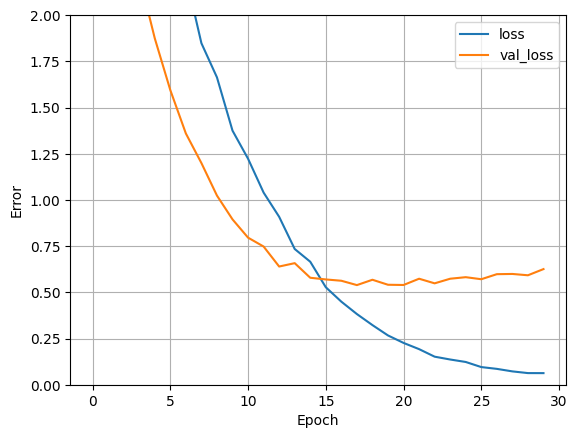

In [23]:
plot_loss(history)

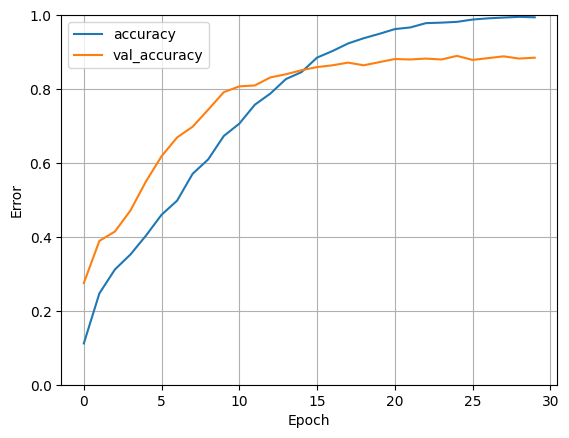

In [24]:
plot_acc(history)

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step


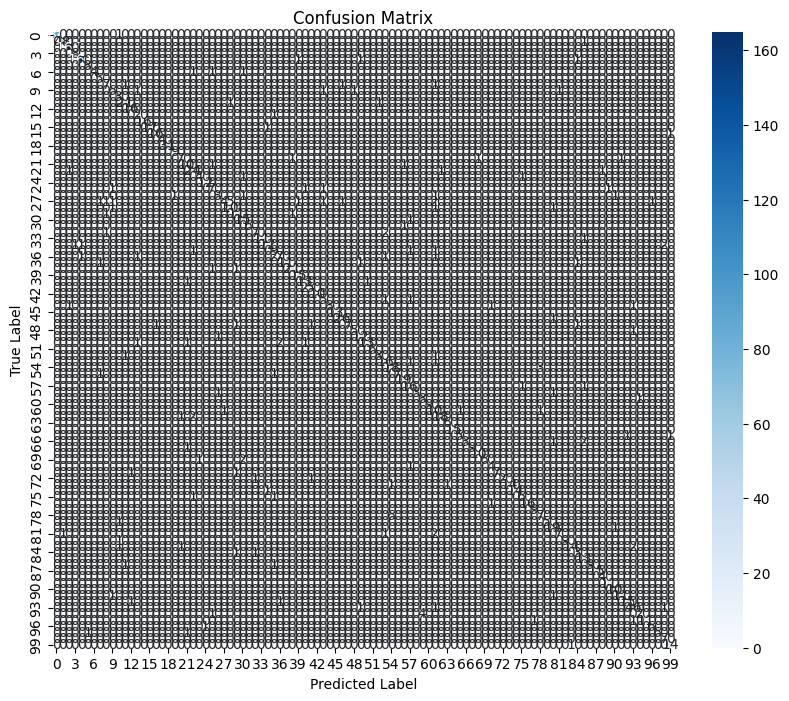

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

predicted_probabilities = model.predict(test_dataset)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Values given are macro")
print("****")
print(f"Precision: {precision_score(y_test, predicted_labels, average='macro')}")
print(f"Recall: {recall_score(y_test, predicted_labels, average='macro')}")
print(f"Macro F1: {f1_score(y_test, predicted_labels, average='macro')}")

Values given are macro
****
Precision: 0.8555643297521458
Recall: 0.8378981939522089
Macro F1: 0.8350514089139027
